# Описание ДЗ-2.

В второй домашке необходимо реализовать различные модификации градинетного спуска.

За дз можно получить максимум 10 баллов. **Домашки довольно творческие, если замечу копию нотбука у другого студента то максимальный балл сниижается до 3 )**

Разбалловка:
*   **Воспроизводимость и читабельность кода -  6 баллов** (все воспроизвелось и все понятно для проверяющего - 6 баллов; есть непонятные моменты, но все воспроизвелось - 4 балла; непонятный код и/или воспроизводится с небольшой правкой - 2 балл; непонятный код и/или ничего не воспроизвелось - 0 баллов).
*   **Технический отчет - 4 балла** (приведены результаты сравнения и выводы что сделали чтоб перебить baseline\другую модель, к примеру одна модель лучше/хуже нейронки и тд - 4 балла, только результаты - 2 балл, ничего нет - 0 баллов).


Присылать домашки по ссылке https://forms.gle/W8jwbwA4EWagEbX66

In [88]:
import numpy as np
import matplotlib.pyplot as plt

## Генерация выборки

Для наших целей будем использовать искуственно сгенерированные данные.

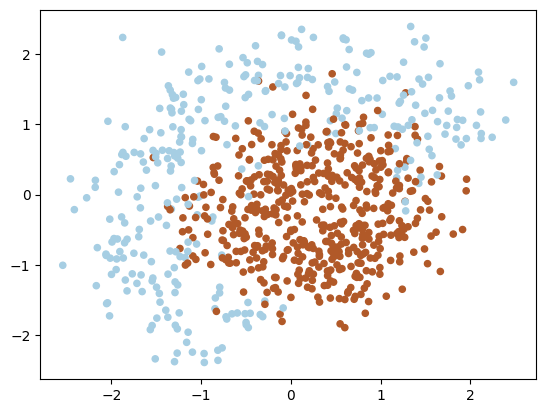

In [89]:
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(
    n_samples=1024,
    shuffle=True,
    noise=0.2,
    factor=0.4,
    random_state=42,
)
ind = np.logical_or(y == 1, X[:, 1] > X[:, 0] - 0.5)
X = X[ind, :]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=20)
plt.show()

### [1] Варка фичей

Как вы можете заметить, данные не являются линейно разделимыми. Нам придётся добавить в обучающую выборку новые фичи либо использовать нелинейные модели. Предположим, что разделяющая поверхность имеет вид окружности. Добавьте в матрицу признаков дополнительные колонки $x_1^2$, $x_2^2$ и $x_1 \cdot x_2$.

In [90]:
def expand(X):
    n_samples = X.shape[0]
    X_expanded = np.zeros((n_samples, 6))
    X_expanded[:, 0] = X[:, 0]
    X_expanded[:, 1] = X[:, 1]
    X_expanded[:, 2] = X[:, 0] ** 2
    X_expanded[:, 3] = X[:, 1] ** 2
    X_expanded[:, 4] = X[:, 0] * X[:, 1]
    X_expanded[:, 5] = 1
    return X_expanded

### [3] Логистическая регрессия

Для классификации будем использовать логистическую регрессию.

$$ a(x; w) = \langle w, x \rangle $$
$$ P( y=1 \; \big| \; x, \, w) = \dfrac{1}{1 + \exp(- \langle w, x \rangle)} = \sigma(\langle w, x \rangle)$$


In [91]:
def probability(X, w):
    a = np.dot(X, w)
    p = 1 / (1 + np.exp(-a))
    return p

Для логистической регрессии оптимальный параметр находится минимизацией кросс-энтропии:

$$ L(w) =  - {1 \over \ell} \sum_{i=1}^\ell \left[ {y_i \cdot log P(y_i = 1 \, | \, x_i,w) + (1-y_i) \cdot log (1-P(y_i = 1 \, | \, x_i,w))}\right] $$



In [92]:
def compute_loss(X, y, w):
    p = probability(X, w)
    loss = -np.mean(y * np.log(p) + (1 - y) * np.log(1 - p))
    return loss

Мы будем обучать модель методом градиентного спуска. Для этого нам придётся вычислить градиент функции потерь, представленной выше. Возьмите листочек, ручку и в бой!

$$ \nabla_w L = ...$$

Тут обойдёмся даже без матричного дифириенцирования. А вот в следущий раз его не миновать...

In [93]:
def compute_grad(X, y, w):
    p = probability(X, w)
    grad = np.dot(X.T, (p - y)) / len(y)

    return grad

Функция ниже предназначена для визуализации процесса обучения.

In [94]:
from IPython import display

h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))


def visualize(X, y, w, history):
    Z = probability(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 2, 1)
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    plt.subplot(1, 2, 2)
    plt.plot(history)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    plt.show()

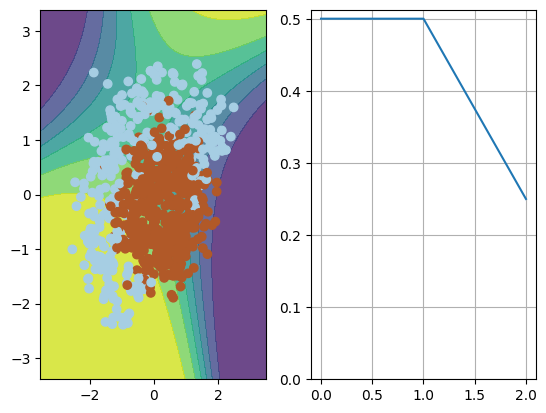

In [95]:
# убедитесь, что у вас она работает, запустив код ниже
# (он отработает если вы верно реализовали expend и probability)
dummy_weights = np.linspace(-1, 1, 6)
visualize(X, y, dummy_weights, [0.5, 0.5, 0.25])

## Обучение

Пришло время обучить нашу модель. Для этого вам придётся дописать кусочки функций ниже. Обязательно попробуйте поменять гиперпараметры (размер батча и скорость обучения) и посмотреть как будет изменяться анимация.

### [2] Mini-batch SGD

Берём несколько рандомных наблюдений и ищем градиент по ним!

$$ w_t = w_{t-1} - \eta \dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$



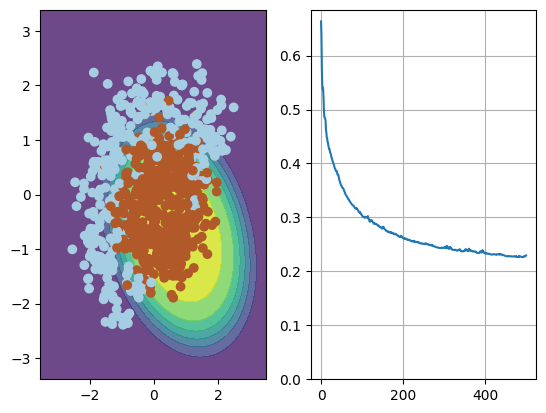

<Figure size 640x480 with 0 Axes>

In [96]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.1

n_iter = 500
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    indices = np.random.choice(X.shape[0], batch_size)
    X_batch = X[indices]
    y_batch = y[indices]

    X_batch_expanded = expand(X_batch)

    grad = compute_grad(X_batch_expanded, y_batch, w)

    w = w - eta * grad

    X_expanded = expand(X)
    loss[i] = compute_loss(X_expanded, y, w)

    if i % 10 == 0:
        visualize(X, y, w, loss[: i + 1])

visualize(X, y, w, loss)
plt.clf()

### [2] Momentum SGD

Momentum это метод, который помогает стохастическому градиентному спуску сохранять направление движения. Это осуществляется за счёт добавления в выражение дополнительного слагаемого: накопленного за предыдущие шаги градиента с весом $\alpha$.
<br>
<br>

$$ \nu_t = \alpha \nu_{t-1} + \eta\dfrac{1}{m} \sum_{j=1}^m \nabla_w L(w_t, x_{i_j}, y_{i_j}) $$
$$ w_t = w_{t-1} - \nu_t$$


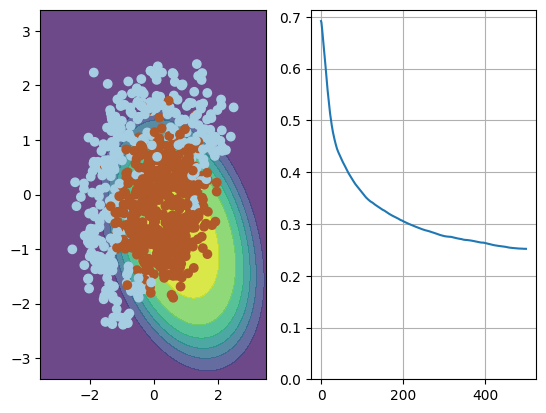

<Figure size 640x480 with 0 Axes>

In [97]:
np.random.seed(42)
w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.05
alpha = 0.9
nu = np.zeros_like(w)

n_iter = 500
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))

for i in range(n_iter):
    indices = np.random.choice(X.shape[0], batch_size)
    X_batch = X[indices]
    y_batch = y[indices]

    X_batch_expanded = expand(X_batch)

    grad = compute_grad(X_batch_expanded, y_batch, w)

    nu = alpha * nu + (1 - alpha) * grad
    w = w - eta * nu

    X_expanded = expand(X)
    loss[i] = compute_loss(X_expanded, y, w)

    if i % 10 == 0:
        visualize(X, y, w, loss[: i + 1])

visualize(X, y, w, loss)
plt.clf()

### [2] RMSprop

В этом блоке реализуем RMSprop. Эта вариация градиентного спуска позволяет изменять скорость обучения индивидуально для каждого параметра.

$$ G_t^j = \alpha G_{t-1}^j + (1 - \alpha) g_{tj}^2 $$
$$ w_t^j = w_{t-1}^j - \dfrac{\eta}{\sqrt{G_t^j + \varepsilon}} g_{tj} $$

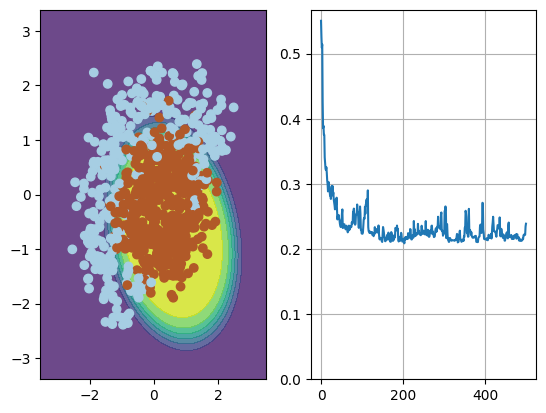

<Figure size 640x480 with 0 Axes>

In [98]:
np.random.seed(42)

w = np.array([0, 0, 0, 0, 0, 1])

eta = 0.1
alpha = 0.9
g2 = np.zeros_like(w)
eps = 1e-8

n_iter = 500
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12, 5))
for i in range(n_iter):
    indices = np.random.choice(X.shape[0], batch_size)
    X_batch = X[indices]
    y_batch = y[indices]

    X_batch_expanded = expand(X_batch)

    grad = compute_grad(X_batch_expanded, y_batch, w)

    g2 = alpha * g2 + (1 - alpha) * grad**2
    w = w - eta * grad / (np.sqrt(g2) + eps)

    X_expanded = expand(X)
    loss[i] = compute_loss(X_expanded, y, w)

    if i % 10 == 0:
        visualize(X, y, w, loss[: i + 1])

visualize(X, y, w, loss)
plt.clf()

Как траектории обучения различных вариаций градиентного спуска различаются между собой? Ожидаемо ли это? Почему? Что нужно сделать, чтобы реализовать Adam?

1. **Mini-batch SGD**: Имеет нестабильную траекторию с множеством колебаний. Сходится относительно медленно, траектория "шумная".

2. **Momentum SGD**: Сглаживает траекторию обучения по сравнению с обычным SGD, демонстрирует меньше резких скачков. Обладает "инерцией", что позволяет ему преодолевать локальные минимумы и плато.

3. **RMSprop**: Показывает более быструю сходимость и лучший результат, но меньшую стабильность. Адаптивный шаг позволяет точнее настраивать параметры в зависимости от характеристик градиента.

Эти различия ожидаемы, так как:
- **Mini-batch SGD** сильно зависит от выбранных батчей и может "застревать" в локальных минимумах.
- **Momentum** добавляет инерцию движения, что позволяет преодолевать локальные неровности и ускоряет движение в перспективных направлениях.
- **RMSprop** адаптирует шаг для каждого параметра отдельно, что делает его эффективным для признаков с разной масштабностью и частотой изменений.

### Реализация Adam
Для реализации Adam (Adaptive Moment Estimation) нужно:

1. Комбинировать идеи Momentum и RMSprop
2. Отслеживать два момента для каждого параметра:
    - Первый момент (m) - экспоненциальное скользящее среднее градиентов (как в Momentum)
    - Второй момент (v) - экспоненциальное скользящее среднее квадратов градиентов (как в RMSprop)
3. Применить коррекцию смещения для обоих моментов
4. Обновлять параметры с учетом этих моментов

### [2] За каждую адекватную вариацию

Если понравилось реализовывать свои градиентные спуски и ты находишься от них под глубоким впечатлением, я могу накинуть дополнительные баллы за реализацию каждой новой адекватной вариации.

In [99]:
# Ваш код здесь